In [1]:
import nuscenes
import numpy as np

In [3]:
nusc = nuscenes.NuScenes(version='v1.0-trainval', dataroot='/data/Datasets/nuScenes', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 30.8 seconds.
Reverse indexing ...
Done reverse indexing in 9.0 seconds.


In [5]:
sample = nusc.sample[13]

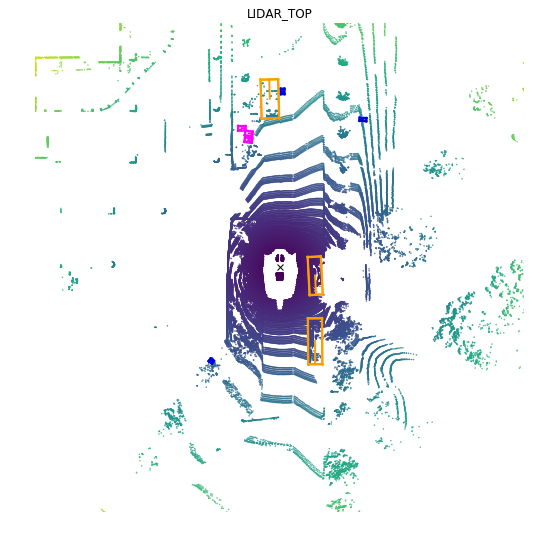

In [7]:
nusc.render_sample_data(nusc.get('sample_data', sample['data']['LIDAR_TOP'])['token'], nsweeps=5)

In [8]:
lidar_path, boxes, _ = nusc.get_sample_data(nusc.get('sample_data', sample['data']['LIDAR_TOP'])['token'])

In [9]:
lidar_path

'/data/Datasets/nuScenes/samples/LIDAR_TOP/n015-2018-07-18-11-07-57+0800__LIDAR_TOP__1531883536948304.pcd.bin'

In [20]:
points = np.fromfile(lidar_path, dtype=np.float32).reshape([-1, 5])[:, :4].T

In [21]:
points.shape

(4, 34688)

In [22]:
from nuscenes.utils.geometry_utils import transform_matrix
from pyquaternion import Quaternion

In [23]:
curr_sd_rec = nusc.get('sample_data', nusc.get('sample', sample['token'])['data']['LIDAR_TOP'])
ego_pose = nusc.get('ego_pose', curr_sd_rec['ego_pose_token'])
calibrated_sensor = nusc.get('calibrated_sensor', curr_sd_rec['calibrated_sensor_token'])

In [24]:
global_from_car = transform_matrix(
                    ego_pose['translation'],
                    Quaternion(ego_pose['rotation']),
                    inverse=False)
car_from_current = transform_matrix(
                    calibrated_sensor['translation'],
                    Quaternion(calibrated_sensor['rotation']),
                    inverse=False)

tm = np.dot(global_from_car, car_from_current)

In [25]:
nbr_points = points.shape[1]
points[:3, :] = tm.dot(np.vstack((points[:3, :], np.ones(nbr_points))))[:3, :]
points = points.T
print(points.shape)

(34688, 4)


In [26]:
for i in range(points.shape[1]):
    print(points[:, i].min(), points[:, i].max())

893.9964 1069.5405
559.84625 696.88324
-17.827595 12.078074
0.0 255.0


In [27]:
from matplotlib import pyplot as plt

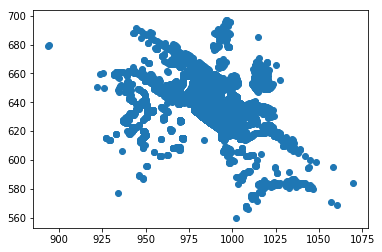

In [42]:
plt.scatter(points[:, 0],points[:, 1])
plt.show()

In [30]:
scene = nusc.get('scene', nusc.get('sample', sample['token'])['scene_token'])
scene_token = scene['token']
scene_record = nusc.get('scene', scene_token)
log_record = nusc.get('log', scene_record['log_token'])
map_record = nusc.get('map', log_record['map_token'])
map_mask = map_record['mask']

In [39]:
cropped = map_mask.mask()[8940:10695, 5599: 6969]

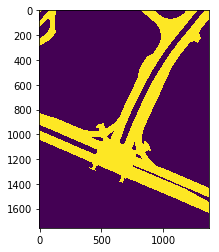

In [40]:
plt.imshow(cropped)

In [44]:
ego_pose['translation']

[990.0116273973956, 635.0710214583562, 0.0]

In [45]:
map_pose = np.concatenate(map_mask.to_pixel_coords(ego_pose['translation'][0], ego_pose['translation'][1]))

In [46]:
map_pose.shape

(2,)

In [47]:
map_pose

array([ 9900, 13899], dtype=int32)

In [53]:
filtered = map_mask.is_on_mask(x=points[:, 0], y=points[:, 1])

In [54]:
filtered_points = points[filtered]

In [55]:
filtered_points.shape

(18743, 4)

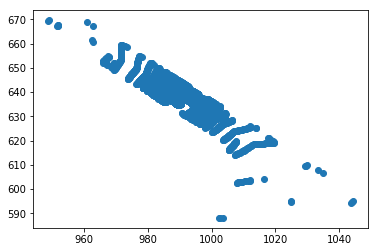

In [56]:
plt.scatter(filtered_points[:, 0],filtered_points[:, 1])
plt.show()

In [59]:
x_min = map_pose[0] - int(50.4/0.1)
x_max = map_pose[0] + int(50.4/0.1)
y_min = map_pose[1] - int(50.4/0.1)
y_max = map_pose[1] + int(50.4/0.1)
cropped2 = map_mask.mask()[y_min:y_max, x_min:x_max, ]

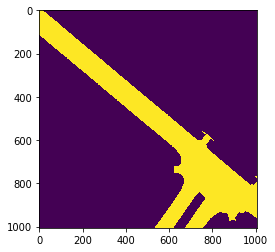

In [60]:
plt.imshow(cropped2)